In [1]:
import jax
from jax.config import config

# very important- otherwise, JAX will use 32-bit floats by default
config.update("jax_enable_x64", True)

# optional but useful for debugging- will raise an error if any nans appear
config.update("jax_debug_nans", True)

import jax.numpy as jnp
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.jplhorizons import Horizons
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore', module='erfa')

from jorbit import Observations, Particle, System

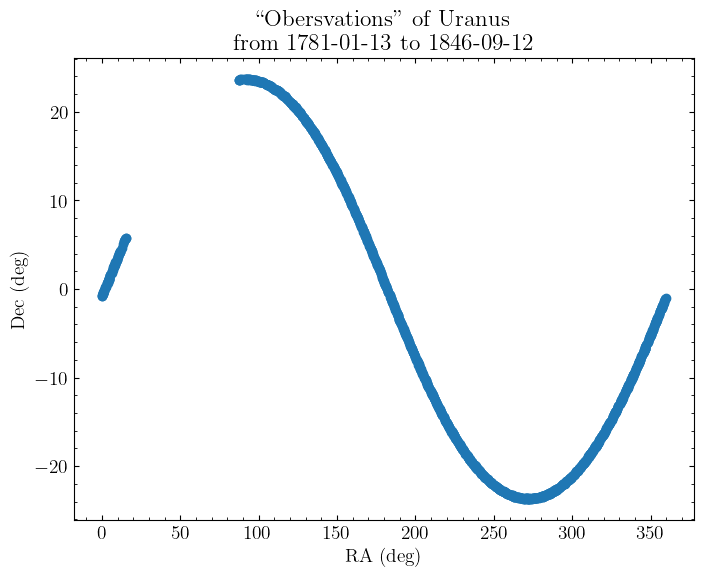

In [2]:
uranus_discovery = Time('1781-01-13 00:00')
neptune_discovery = Time('1846-09-23 00:00')
times = Time(jnp.arange(uranus_discovery.jd,
                        neptune_discovery.jd, 21), format='jd')


data = Observations.horizons_astrometry_query(target='uranus barycenter',
                                       center='548@399', times=times)

uranus_observations = SkyCoord(data.RA, data.Dec, unit=u.deg)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(uranus_observations.ra.deg, uranus_observations.dec.deg)
t0 = times[0].iso.split(" ")[0]
tf = times[-1].iso.split(" ")[0]
ax.set(
    xlabel="RA (deg)",
    ylabel="Dec (deg)",
    title=f"``Obersvations\" of Uranus\nfrom {t0} to {tf}",
);



In [3]:
obs = Observations(
    positions=uranus_observations,
    times=times,
    observatory_locations='Berlin (1835-1913)',
    astrometry_uncertainties=1*u.arcsec)


init_uranus = Observations.horizons_vector_query(target='uranus barycenter',
                                   center='500@0', times=times[0]).iloc[0]

init_neptune = Observations.horizons_vector_query(target='neptune barycenter',
                                   center='500@0', times=times[0]).iloc[0]

In [15]:
uranus = Particle(
    x=jnp.array([init_uranus.x, init_uranus.y, init_uranus.z]),
    v=jnp.array([init_uranus.vx, init_uranus.vy, init_uranus.vz]),
    time=times[0],
    gm=1.2920265649682398e-08,
    observations=obs, 
    free_orbit=True,
    free_gm=False,
    earliest_time=Time('1750-01-01'),
    latest_time=Time('1900-01-01'),
)

neptune_good = Particle(
    x=jnp.array([init_neptune.x, init_neptune.y, init_neptune.z]),
    v=jnp.array([init_neptune.vx, init_neptune.vy, init_neptune.vz]),
    time=times[0],
    gm=1.5243573478851935e-08,
    free_orbit=True,
    free_gm=True)

neptune_heavy = Particle(
    x=jnp.array([init_neptune.x, init_neptune.y, init_neptune.z]),
    v=jnp.array([init_neptune.vx, init_neptune.vy, init_neptune.vz]),
    time=times[0],
    gm=1.5243573478851935e-08*1.01,
    free_orbit=True,
    free_gm=True)

# , 'Astraea'
sim1 = System(particles=[uranus],
             planets=['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Neptune'],
             asteroids=['Ceres', 'Pallas', 'Juno', 'Vesta'])

print(sim1.loglike)

sim2 = System(particles=[uranus, neptune_good],
             planets=['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn'],
             asteroids=['Ceres', 'Pallas', 'Juno', 'Vesta'])

print(sim2.loglike)

sim3 = System(particles=[uranus, neptune_heavy],
                planets=['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn'],
                asteroids=['Ceres', 'Pallas', 'Juno', 'Vesta'])

print(sim3.loglike)

-0.47078497283394705
-0.4707460532859289
-494.6883543691174


In [21]:
tmp = Observations.horizons_vector_query(
                    "3", '695@399', Time('2023-01-01')
                ).iloc[0]
tmp[['x', 'y', 'z']].values
jnp.array([tmp.x, tmp.y, tmp.z])

Array([-9.10796620e-06,  2.33267882e-05, -1.58175386e-05], dtype=float64)

In [10]:
def dummy(m):
    neptune = Particle(
        x=jnp.array([init_neptune.x, init_neptune.y, init_neptune.z]),
        v=jnp.array([init_neptune.vx, init_neptune.vy, init_neptune.vz]),
        time=times[0],
        gm=m[0],
        free_orbit=True,
        free_gm=True)
    sim = System(particles=[uranus, neptune],
                    planets=['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn'],
                    asteroids=['Ceres', 'Pallas', 'Juno', 'Vesta'])
    return jnp.log(-sim.loglike)

from scipy.optimize import minimize
import numpy as np
minimize(dummy, np.array([1.5243573478851935e-08*2]))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 14.001718126672792
        x: [ 7.795e-09]
      nit: 6
      jac: [-3.695e-01]
 hess_inv: [[ 1.698e-16]]
     nfev: 102
     njev: 51